In [1]:
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

The below code is a changed version of gan code at internet. I just arranged it to try lots of different architectures at once. Method get real and fake data generator as parameter.

n_epochs = number of epochs to run

n_eval = at which intervals we will evaluate the models.

latent_dim = how may neurons(nodes)

n_inputs = it is for dimension of input.



In [0]:
class gan_gen:
    def __init__(self,name,generate_real_samples,generate_latent_points,n_epochs,n_eval,latent_dim,n_inputs,is_3d=True,combined_plot=False):    
        self.name = name
        self.generate_real_samples = generate_real_samples
        self.generate_latent_points = generate_latent_points     
        self.n_epochs = n_epochs     
        self.n_eval = n_eval     
        self.latent_dim = latent_dim
        self.n_inputs = n_inputs
        self.is_3d = is_3d
        self.combined_plot = combined_plot
        
    # define the combined generator and discriminator model, for updating the generator
    def define_gan(self,generator, discriminator):
        # make weights in the discriminator not trainable
        discriminator.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(generator)
        # add the discriminator
        model.add(discriminator)
        # compile model
        model.compile(loss='binary_crossentropy', optimizer='adam')        
        return model
      
    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self,generator, latent_dim, n):
      # generate points in latent space
      x_input = generate_latent_points(latent_dim, n)
      # predict outputs
      X = generator.predict(x_input)
      # create class labels
      y = zeros((n, 1))
      return X, y  
    
    def train(self,g_model, d_model, gan_model, latent_dim, n_epochs, n_eval, n_batch=64):
        print("parameters latent_dim:",latent_dim, " epochs " ,n_epochs," summary :", n_eval," batch ", n_batch)
        # determine half the size of one batch, for updating the discriminator
        half_batch = int(n_batch / 2)
        
        counter = 0

        #hold losses,accuracy and generated points for plotting
        losses_discriminator_real = []
        losses_discriminator_fake = []
        losses_generator = []
        real_values = []
        fake_values = []
        acc_discriminator_real = []
        acc_discriminator_fake = []
        # manually enumerate epochs
        for i in range(n_epochs):
            # prepare real samples
            x_real, y_real = self.generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = self.generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator
            d_model.train_on_batch(x_real, y_real)
            d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = self.generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            gan_model.train_on_batch(x_gan, y_gan)
            # evaluate the model every n_eval epochs
            if (i+1) % n_eval == 0:
                g_loss  = gan_model.test_on_batch(x_gan, y_gan)
                losses_generator.append(g_loss)
                
                counter = counter + 1
                performance_metrics = self.summarize_performance(counter,i, g_model, d_model, latent_dim) 
                losses_discriminator_real.append(performance_metrics[0] )
                losses_discriminator_fake.append(performance_metrics[1] )
                acc_discriminator_real.append(performance_metrics[4] )
                acc_discriminator_fake.append(performance_metrics[5] )
                real_values.append(performance_metrics[2] )
                fake_values.append(performance_metrics[3] )
        pyplot.show()        
        if self.combined_plot :
          self.draw_plots2d(real_values,fake_values,"step ")
        else :
          self.draw_plots(real_values,"real ")
          self.draw_plots(fake_values,"fake ")
        
        return (losses_generator,losses_discriminator_real,losses_discriminator_fake,real_values,fake_values,acc_discriminator_real,acc_discriminator_fake)
                
    # evaluate the discriminator and plot real and fake points
    def summarize_performance(self,counter,epoch, generator, discriminator, latent_dim, n=200):
        # prepare real samples
        x_real, y_real = self.generate_real_samples(n)
        # evaluate discriminator on real examples
        loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)        
        # prepare fake examples
        x_fake, y_fake = self.generate_fake_samples(generator, latent_dim, n)
        # evaluate discriminator on fake examples
        loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)                
        return [loss_real,loss_fake,x_real,x_fake,acc_real,acc_fake]
        
        
    def define_discriminator(self,n_inputs):
        model = Sequential()
        lrel = LeakyReLU(alpha=0.3)

        model.add(Dense(25, activation=lrel, kernel_initializer='he_uniform', input_dim=n_inputs))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
 
    # define the standalone generator model
    def define_generator(self,latent_dim):
        model = Sequential()
        init = RandomNormal(mean=0.0, stddev=0.02)
        lrel = LeakyReLU(alpha=0.3)
        model.add(Dense(30, activation=lrel, kernel_initializer=init, input_dim=latent_dim))
        model.add(Dense(self.n_inputs, activation='linear'))
        return model    
        
    def run(self):         
        # create the discriminator
        discriminator = self.define_discriminator(self.n_inputs)
        # create the generator
        generator = self.define_generator(self.latent_dim)
        # create the gan
        gan_model = self.define_gan(generator, discriminator)
        # train model
        losses = self.train(generator, discriminator, gan_model,self.latent_dim, self.n_epochs,self.n_eval)
        self.draw_metrics( losses )
        return losses
      
    def draw_metrics(self,losses):    
      fig, ax = plt.subplots()
      plt.plot(losses[0], label='Generator')
      plt.plot(losses[1], label='Discriminator Real')
      plt.plot(losses[2], label='Discriminator Fake')
      plt.title("Training Losses")
      plt.legend()
      plt.show()
      fig, ax = plt.subplots()
      plt.plot(losses[5], label='Acc Real')
      plt.plot(losses[6], label='Acc Fake')
      plt.title("Training Acc")
      plt.legend()
      plt.show()
      
    def draw_plots(self,milestone_points,label):
      if  self.is_3d :
        self.draw_plots3d(milestone_points,label)
      else :
        self.draw_plots2d(milestone_points,label)


    def draw_plots3d(self,milestone_points,label):
      #plt.figure(figsize=(20,20)) 
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestone_points)):    
        points = milestone_points[i]
        ax = fig.add_subplot(5,5,i+1, projection='3d')
        ax.set_title(label+str(i+1))
        ax.scatter(points[:,0:1],points[:,1:2],points[:,2] , c='r', zorder=10) 
              

    def draw_plots2d(self,milestones1,milestones2,label):
      #plt.figure(figsize=(20,20)) 
      fig = pyplot.figure(figsize=(20,20))
      for i in range(len(milestones1)):    
        points1 = milestones1[i]
        points2 = milestones2[i]
        ax = fig.add_subplot(5,5,i+1)
        ax.set_title(label+" "+str( (i+1) * self.n_eval ))
        ax.scatter(points1[:,0:1],points1[:,1:2]) 
        ax.scatter(points2[:,0:1],points2[:,1:2]) 

Let's try circle. Circle is difficult because it is a not simple function. 1 x can map to multiple y. As we see after 20000 step we see smooth results. 

parameters latent_dim: 100  epochs  50000  summary : 5000  batch  64


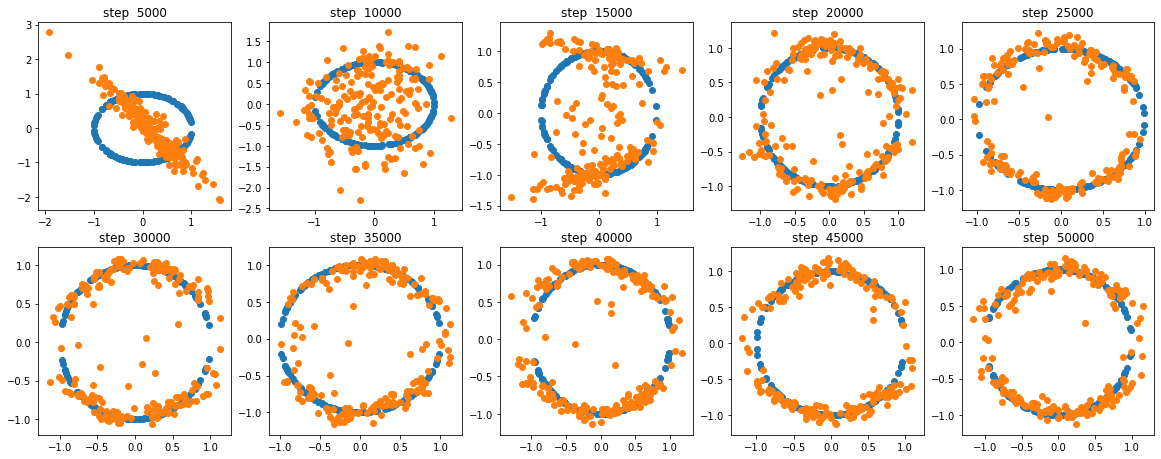

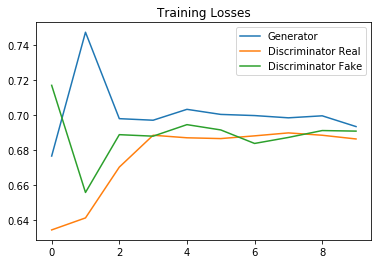

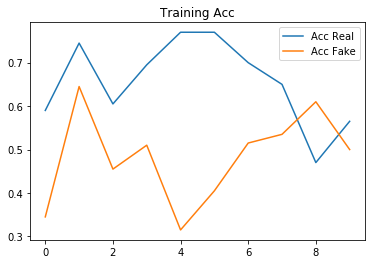

In [20]:
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input      
    
def calculate(x,r,multip):
  r2 = r * r
  x2 = x **2
  return np.sqrt(r2 - x2) * multip

def generate_real_samples(n):
  # generate inputs in [-0.5, 0.5]
  X1 = rand(int(n/2)) * 2 - 1
  #print(X1.shape)
  inputs = list(X1) + list(X1)
  outputs = [calculate(x,1,1) for x in X1] + [calculate(x,1,-1)  for x in X1]
  #print(len(inputs))
  #print(len(outputs))
  # generate outputs X^2
  X2 = np.array( outputs)
  X1 = np.array(inputs)
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

gg = gan_gen("step ",generate_real_samples,generate_latent_points,n_epochs=50000,n_eval=5000  ,latent_dim=100,n_inputs=2 ,is_3d=False,combined_plot=True )

res2dline = gg.run() 

Not lets make circle a simple function by taking only lower part of circle. With this simplification we can see after 3000 epochs we see meaningfull results. 

parameters latent_dim: 100  epochs  30000  summary : 3000  batch  64


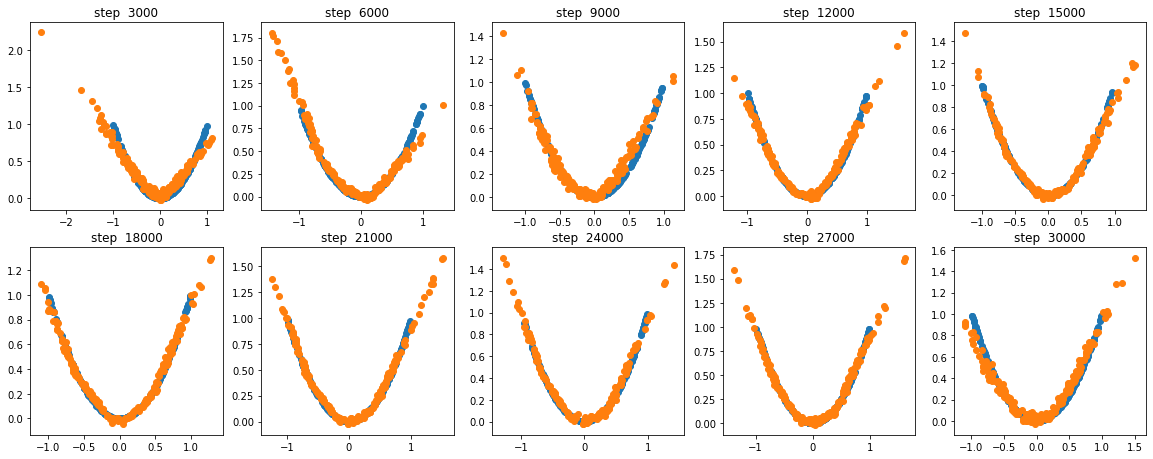

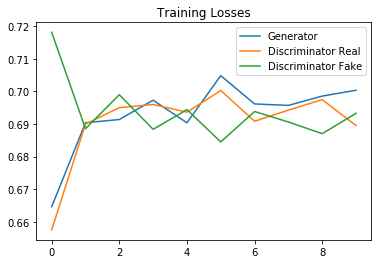

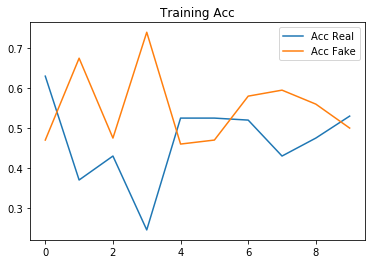

In [22]:
def generate_latent_points(latent_dim, n):
  # generate points in the latent space
  x_input = randn(latent_dim * n)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n, latent_dim)
  return x_input      
    


def generate_real_samples(n):
  # generate inputs in [-0.5, 0.5]
  X1 = rand( n) * 2 - 1  
  X2 = X1 ** 2
  
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y


gg = gan_gen("step",generate_real_samples,generate_latent_points,30000,3000  ,100,2 ,False,True )
res2parabol = gg.run() 